In [13]:
import pandas as pd

event_type = pd.read_parquet("dim_event_type.parquet")
event_log_df = pd.read_parquet("fact_behavior_event.parquet")
event_log_df = pd.merge(event_log_df,event_type, on='event_type_sk')
event_log_df['event_timestamp'] = pd.to_datetime(event_log_df['event_timestamp'])
event_log_df['date'] = event_log_df['event_timestamp'].dt.date
new_data= event_log_df.drop(['event_type_sk', 'recommendation_sk', 'description','plan_sk' , 'event_date_sk','search_query' , 'end_reason' ], axis=1)

In [25]:
import pandas as pd

# 데이터 예시 가정: data라는 DataFrame이 있음
# 필요한 컬럼: user_sk, event_type, event_timestamp

# 1. event_timestamp 컬럼을 datetime으로 변환
new_data['event_timestamp'] = pd.to_datetime(new_data['event_timestamp'])


# 2. 전체 데이터 기간 확인 (2개월로 주어졌는지 확인용)
start_date = new_data['event_timestamp'].min()
end_date = new_data['event_timestamp'].max()
total_days = (end_date - start_date).days
total_months = total_days / 30  # 약산적으로 월 계산

print(f"데이터 수집 기간: {start_date.date()} ~ {end_date.date()} ({total_months:.2f}개월)")

# 3. user_sk, event_type 별 발생 횟수 계산
event_counts = new_data.groupby(['user_sk', 'event_type']).size().reset_index(name='count')

# 4. 평균 월간 이벤트 횟수 계산
event_counts['avg_events_per_month'] = event_counts['count'] / total_months

# 5. 결과 보기 (예시로 user_sk=4854만 보기)
# print(event_counts[event_counts['user_sk'] == 4854])

# 6. 전체 결과 DataFrame 반환
# 필요시: pivot 형태로 변환 (행=user_sk, 열=event_type, 값=avg_events_per_month)
result_pivot = event_counts.pivot(index='user_sk', columns='event_type', values='avg_events_per_month').fillna(0)

row_sums = result_pivot.sum(axis=1)

# 5점 만점으로 정규화
result_pivot = result_pivot.div(row_sums, axis=0).fillna(0) * 5




데이터 수집 기간: 2025-03-01 ~ 2025-06-01 (3.07개월)


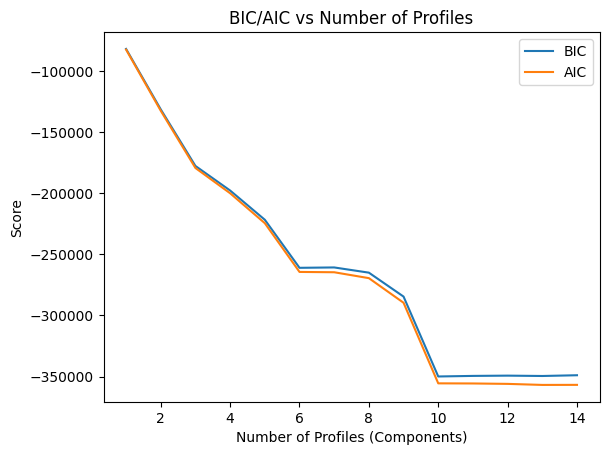

🔹 Cluster Size & Ratio (%):
Profile 0: 662 users (6.62%)
Profile 1: 941 users (9.41%)
Profile 2: 948 users (9.48%)
Profile 3: 1480 users (14.80%)
Profile 4: 847 users (8.47%)
Profile 5: 1962 users (19.62%)
Profile 6: 1605 users (16.05%)
Profile 7: 1555 users (15.55%)


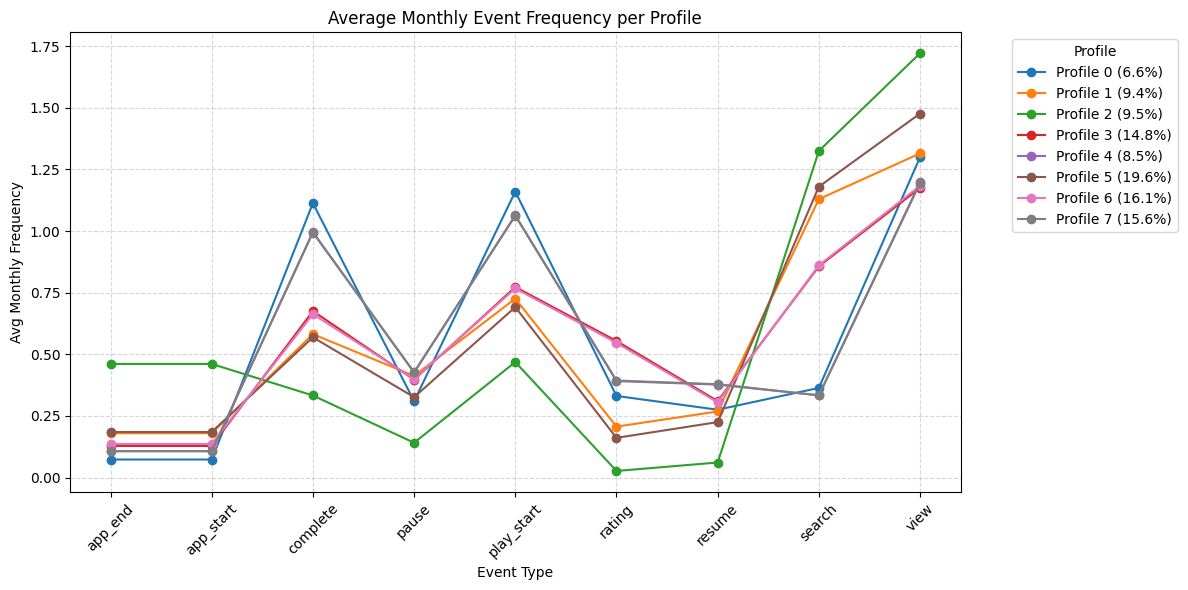


🔸 유저별 클러스터 할당 (상위 10개):
event_type  user_sk  profile
0                 0        6
1                 1        4
2                 2        4
3                 3        4
4                 4        4
...             ...      ...
9995           9995        7
9996           9996        3
9997           9997        2
9998           9998        3
9999           9999        2

[10000 rows x 2 columns]


In [37]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1. 데이터 전처리
X = result_pivot.values  
user_ids = result_pivot.index

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. 최적 군집 수 평가 (AIC/BIC)
n_components_range = range(1, 15)
bics = []
aics = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, covariance_type='full', random_state=42)
    gmm.fit(X_scaled)
    bics.append(gmm.bic(X_scaled))
    aics.append(gmm.aic(X_scaled))

plt.plot(n_components_range, bics, label='BIC')
plt.plot(n_components_range, aics, label='AIC')
plt.xlabel('Number of Profiles (Components)')
plt.ylabel('Score')
plt.legend()
plt.title('BIC/AIC vs Number of Profiles')
plt.show()

# 3. LPA 수행
optimal_n = 8

gmm = GaussianMixture(n_components=optimal_n, covariance_type='full', random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)
probs = gmm.predict_proba(X_scaled)

# 4. 결과 저장
result_pivot['profile'] = labels
result_pivot['user_sk'] = user_ids  
result_pivot = result_pivot.reset_index(drop=True)

# 5. 프로파일별 비율 계산
profile_counts = result_pivot['profile'].value_counts().sort_index()
total_users = len(result_pivot)
profile_ratios = profile_counts / total_users * 100

# 비율 출력
print("🔹 Cluster Size & Ratio (%):")
for i in range(optimal_n):
    count = profile_counts[i]
    ratio = profile_ratios[i]
    print(f"Profile {i}: {count} users ({ratio:.2f}%)")

# 6. 시각화 (띠그래프 + 비율 표시)
plot_data = result_pivot.drop(columns=['user_sk'])
event_types = plot_data.columns[:-1]  # 마지막 열은 profile
profile_means = plot_data.groupby('profile').mean()

plt.figure(figsize=(12, 6))
colors = plt.cm.tab10.colors

for i in range(optimal_n):
    label_text = f'Profile {i} ({profile_ratios[i]:.1f}%)'
    plt.plot(event_types, profile_means.iloc[i], marker='o', label=label_text, color=colors[i % len(colors)])

plt.title('Average Monthly Event Frequency per Profile')
plt.xlabel('Event Type')
plt.ylabel('Avg Monthly Frequency')
plt.legend(title='Profile', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 7. 유저별 클러스터 정보 저장
user_cluster_df = result_pivot[['user_sk', 'profile']]

# 출력 예시
print("\n🔸 유저별 클러스터 할당 (상위 10개):")
print(user_cluster_df)

# CSV로 저장하고 싶다면:
# user_cluster_df.to_csv("user_cluster_assignments.csv", index=False)
